libpng warning: iCCP: extra compressed data
libpng warning: iCCP: extra compressed data


[[0.70306917 0.29693083]
 [0.12522943 0.87477057]
 [0.26137267 0.73862733]
 [0.19655368 0.80344632]
 [0.12718935 0.87281065]
 [0.43559649 0.56440351]
 [0.12229349 0.87770651]
 [0.74842424 0.25157576]
 [0.71313699 0.28686301]
 [0.21700708 0.78299292]
 [0.25991527 0.74008473]
 [0.61923642 0.38076358]
 [0.12359607 0.87640393]
 [0.17927255 0.82072745]
 [0.17600896 0.82399104]
 [0.46396589 0.53603411]
 [0.25328926 0.74671074]
 [0.25991527 0.74008473]
 [0.41738693 0.58261307]
 [0.27573698 0.72426302]
 [0.73753338 0.26246662]
 [0.31507694 0.68492306]
 [0.70216387 0.29783613]
 [0.12246169 0.87753831]
 [0.25468692 0.74531308]
 [0.57925183 0.42074817]
 [0.16342923 0.83657077]
 [0.15833653 0.84166347]
 [0.71888276 0.28111724]
 [0.13728732 0.86271268]
 [0.38508914 0.61491086]
 [0.59725713 0.40274287]
 [0.74842424 0.25157576]
 [0.12646702 0.87353298]
 [0.13735953 0.86264047]
 [0.18431946 0.81568054]
 [0.45511495 0.54488505]
 [0.5        0.5       ]
 [0.33590405 0.66409595]
 [0.13912784 0.86087216]


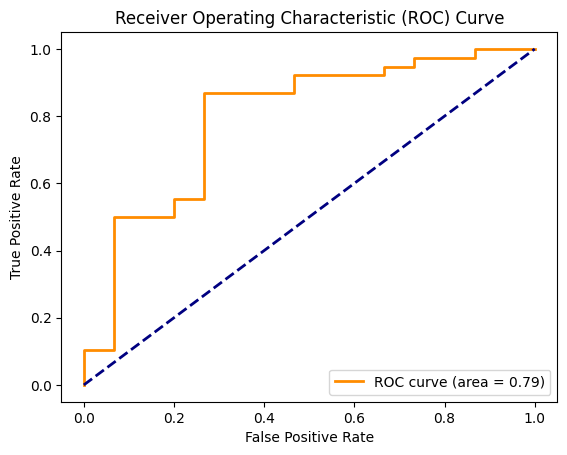

Accuracy: 0.7735849056603774


In [39]:
# Link to dataset : https://drive.google.com/drive/folders/13Fk6D_sB3CGwTxuS3i8FC9ko49xHDsRj?usp=drive_link

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

def preprocess_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Error reading image at: {file_path}")
        return None

    edges = cv2.Canny(img, 100, 200)
    _, segmented_img = cv2.threshold(edges, 128, 255, cv2.THRESH_BINARY)
    resized_img = cv2.resize(segmented_img, (64, 64))
    normalized_img = resized_img / 255.0

    # Add channel dimension
    return np.expand_dims(normalized_img, axis=-1)

def load_dataset(data_dir):
    images = []
    labels = []

    for category in os.listdir(data_dir):
        category_dir = os.path.join(data_dir, category)

        if os.path.isdir(category_dir):
            for file_name in os.listdir(category_dir):
                file_path = os.path.join(category_dir, file_name)

                if os.path.isfile(file_path):  # Check if it's a file
                    processed_img = preprocess_image(file_path)

                    if processed_img is not None:
                        images.append(processed_img)
                        labels.append(1 if category == 'cancer' else 0)  # Assign labels
                else:
                    print(f"Ignoring non-file item: {file_path}")

    return np.array(images), np.array(labels)

def augment_data(images):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    for img in images:
        augmented_img = datagen.flow(np.expand_dims(img, axis=0)).next()[0]
        augmented_images.append(augmented_img)

    return np.array(augmented_images)

# Load the dataset
data_dir = './Dataset/oral_cancer'
images, labels = load_dataset(data_dir)

# Augment the data
augmented_images = augment_data(images)

# Combine original and augmented data
all_images = np.concatenate((images, augmented_images), axis=0)
all_labels = np.hstack((labels, labels))  # Assuming binary classification (cancer or non-cancer)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Flatten the images for SVM
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

# Train an SVM classifier
clf = SVC(probability=True)
clf.fit(X_train_flatten, y_train)

# Testing
y_pred = clf.predict(X_test_flatten)

probabilities = clf.predict_proba(X_test_flatten)

print(probabilities)

print("Predicted :", y_pred, "\n\nTest :", y_test)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test_flatten)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print accuracy
accuracy = clf.score(X_test_flatten, y_test)
print("Accuracy:", accuracy)
